# Neural Network application

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, f1_score
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import utils
import numpy as np
from sklearn.decomposition import PCA

2022-12-03 14:49:21.274201: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [65]:
plt.rcParams['text.usetex'] = True

import time

Load and prepare data:

In [2]:
path = "../data/"
file_pre = "prep_data.csv"
file_data = "CTG.xls"

fetus_pre = pd.read_csv(path+file_pre)
fetus_pre = fetus_pre.reindex(np.random.permutation(fetus_pre.index))
fetus = pd.read_excel(path+file_data, sheet_name = "Data",header=1)
fetus = fetus.reindex(np.random.permutation(fetus.index))
# Columns to be considered in the dataset
columns = ["LB", "AC", "FM", "UC", "DL", "DP", 
           "ASTV", "MSTV", "ALTV", "MLTV", "Width", "Min", 
           "Max", "Nmax", "Nzeros", "Mode", "Mean", "Median", "Variance", "Tendency"]
# Prepocessed dataset
X = fetus_pre[columns]
y = fetus_pre["NSP"]

# Raw dataset
X_raw = fetus[columns]
y_raw = fetus["NSP"]

# One-hot enconding of target values
y_cat = utils.to_categorical(y-1)
y_cat_raw = utils.to_categorical(y_raw-1)

# Split train/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, random_state = 45, train_size = 0.8)

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_cat_raw, random_state = 45, train_size = 0.8)


In [63]:
def evaluate(y_pred, y_test, model):
    
    # Apply argmax
    y_pred = np.argmax(y_pred,axis=1)
    y_compare = np.argmax(y_test,axis=1)
    
    print("Accuracy: %.2f"%accuracy_score(y_pred,y_compare))
    print("Recall: %.2f"%recall_score(y_pred,y_compare,average="macro"))
    
    if model:
    
        fig, (ax1, ax2) = plt.subplots(1,2,figsize = (5,5))
    
        ax1 = plt.plot(model.history['loss'])
        ax1.set_xlabel("Epochs")
        ax1.set_ylabel("Loss")
        
        ax2 = plt.plot(model.history['accuracy'])
        ax2.set_xlabel("Epochs")
        ax2.set_ylabel("Accuracy")

    cm = confusion_matrix(y_compare, y_pred, normalize="all")

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["1","2","3"])
    disp.plot()
    


# PCA

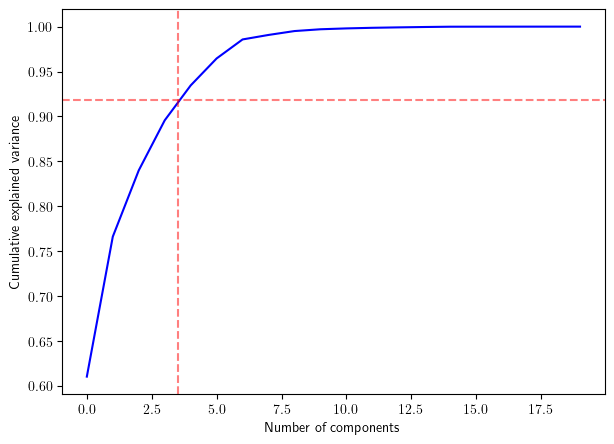

In [35]:
import matplotlib.pyplot as plt
#Apply PCA to raw data
pca = PCA()
pca.fit(X)

fig, ax = plt.subplots(figsize=(7,5))

plt.plot(np.cumsum(pca.explained_variance_ratio_),c="b")
ax.set_xlabel('Number of components')
ax.set_ylabel('Cumulative explained variance');
ax.axhline(0.918, c = "red", linestyle="--", alpha = 0.5)
ax.axvline(3.5, c = "red", linestyle="--", alpha = 0.5)


Applying PCA to both raw and scaled data, the cumulative explained variance displays different trends. A 90% variance is obtained with 3 components for the raw data and for 10 components for the scaled data. 

Text(0.5, 0, 'Component 3')

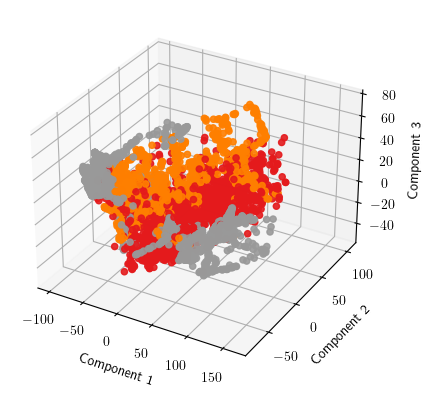

In [36]:
pca = PCA(3) 
X3 = pca.fit_transform(X)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X3[:, 0], X3[:, 1],X3[:, 2], c=y,alpha=0.9, cmap=plt.cm.get_cmap('Set1', 7))

ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")

In [6]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y_cat, random_state = 45, train_size = 0.8)

# Change activation function

## HL(15, sigmoid)

In [67]:
model = Sequential()
model.add(Dense(15, input_dim=X3.shape[1], activation='sigmoid'))
model.add(Dense(y_cat.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

itime = time.time()
model_trace = model.fit(X3_train,y3_train,verbose=0,epochs=100)
fit_time = time.time() - itime

itime = time.time()
y3_pred = model.predict(X3_test)
pred_time = time.time() - itime

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 15)                60        
                                                                 
 dense_55 (Dense)            (None, 3)                 48        
                                                                 
Total params: 108
Trainable params: 108
Non-trainable params: 0
_________________________________________________________________
31/31 [==============================] - 0s 1ms/step


Accuracy: 0.82
Recall: 0.82


AttributeError: 'list' object has no attribute 'set_xlabel'

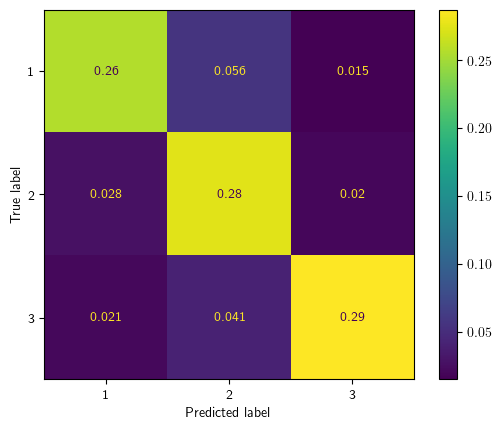

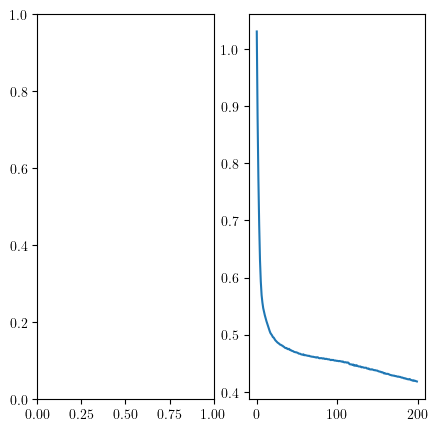

In [53]:
evaluate(y3_pred, y3_test,model_trace)

## HL(15, relu)

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 15)                60        
                                                                 
 dense_73 (Dense)            (None, 3)                 48        
                                                                 
Total params: 108
Trainable params: 108
Non-trainable params: 0
_________________________________________________________________
31/31 [==============================] - 0s 1ms/step
===RESULTS================================
Fit time: 20.847 s
Prediction time: 0.123 s
Accuracy: 0.83
Recall: 0.84


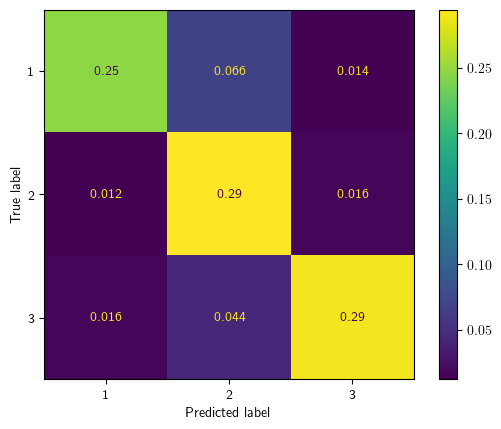

In [74]:
model = Sequential()
model.add(Dense(15, input_dim=X3.shape[1], activation='relu'))
model.add(Dense(y_cat.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

itime = time.time()
model_trace = model.fit(X3_train,y3_train,verbose=0,epochs=100)
fit_time = time.time() - itime

itime = time.time()
y3_pred = model.predict(X3_test)
pred_time = time.time() - itime

print("===RESULTS================================")
print("Fit time: %.3f s"%fit_time)
print("Prediction time: %.3f s"%pred_time)
evaluate(y3_pred, y3_test, None)

# Change nodes in the first layer

In this section, we focus on trying to understand the pros and cons on using PCA in this particular case.

## HL(30, sigmoid)

Parameters difference:

- 3 feat: 213 params
- 20 feat: 723 params

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 30)                120       
                                                                 
 dense_28 (Dense)            (None, 3)                 93        
                                                                 
Total params: 213
Trainable params: 213
Non-trainable params: 0
_________________________________________________________________
31/31 [==============================] - 0s 1ms/step
Accuracy: 0.84
Recall: 0.85


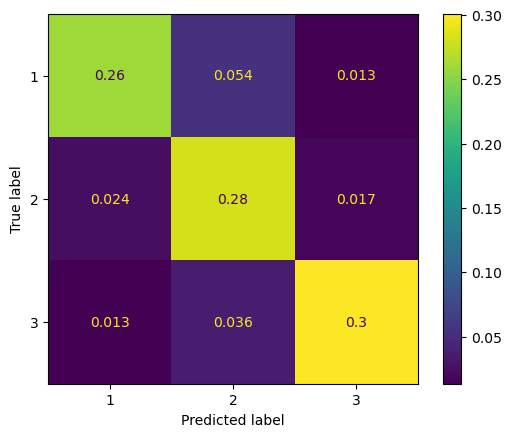

In [33]:
model = Sequential()
model.add(Dense(30, input_dim=X3.shape[1], activation='sigmoid'))
model.add(Dense(y_cat.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

model.fit(X3_train,y3_train,verbose=0,epochs=200)

y3_pred = model.predict(X3_test)

evaluate(y3_pred, y3_test)

## HL(60, sigmoid)

Parameters difference:

- 3 feat: 423 params
- 20 feat: 1443 params

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 60)                240       
                                                                 
 dense_22 (Dense)            (None, 3)                 183       
                                                                 
Total params: 423
Trainable params: 423
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
123/123 [==============================] - 0s 1ms/step - loss: 0.7201
Epoch 2/100
123/123 [==============================] - 0s 1ms/step - loss: 0.5562
Epoch 3/100
123/123 [==============================] - 0s 1ms/step - loss: 0.5286
Epoch 4/100
123/123 [==============================] - 0s 1ms/step - loss: 0.5145
Epoch 5/100
123/123 [==============================] - 0s 1ms/step - loss: 0.5036
Epoch 6/100
123/123 [====================

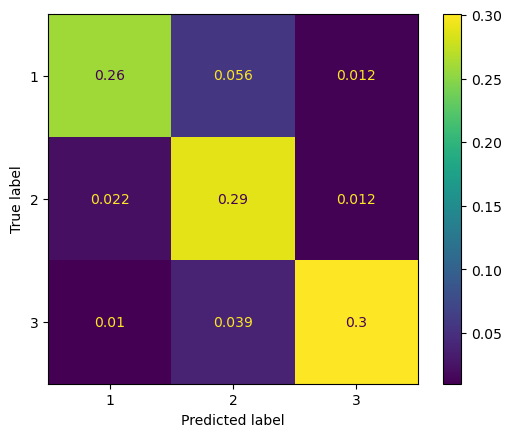

In [29]:
model = Sequential()
model.add(Dense(60, input_dim=X3.shape[1], activation='sigmoid'))
model.add(Dense(y_cat.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

model.fit(X3_train,y3_train,verbose=1,epochs=100)

y3_pred = model.predict(X3_test)

evaluate(y3_pred, y3_test)

# Two or more layers

## HL(15, relu), HL(15, relu)

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_65 (Dense)            (None, 15)                60        
                                                                 
 dense_66 (Dense)            (None, 15)                240       
                                                                 
 dense_67 (Dense)            (None, 3)                 48        
                                                                 
Total params: 348
Trainable params: 348
Non-trainable params: 0
_________________________________________________________________
31/31 [==============================] - 0s 1ms/step
Fit time: 11.807
Prediction time: 0.110
Accuracy: 0.83
Recall: 0.84


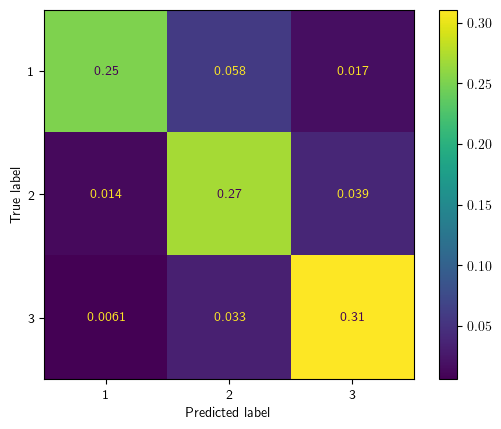

In [71]:
model = Sequential()
model.add(Dense(15, input_dim=X3.shape[1], activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(y_cat.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

itime = time.time()
model_trace = model.fit(X3_train,y3_train,verbose=0,epochs=100)
fit_time = time.time() - itime

itime = time.time()
y3_pred = model.predict(X3_test)
pred_time = time.time() - itime

print("===RESULTS================================")
print("Fit time: %.3f s"%fit_time)
print("Prediction time: %.3f s"%pred_time)
evaluate(y3_pred,y_test,None)

Accuracy: 0.83
Recall: 0.83


AttributeError: 'list' object has no attribute 'set_xlabel'

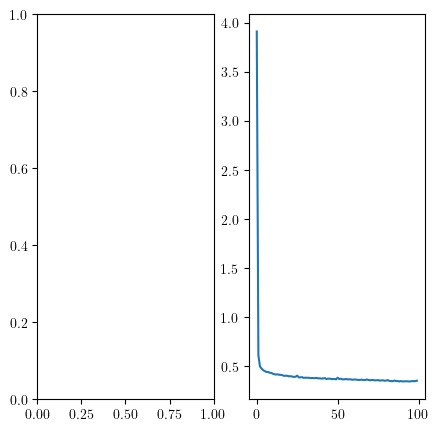

In [62]:
evaluate(y3_pred,y_test,model_trace)

## HL(15, relu), HL(15, relu), HL(15, relu), HL(15, relu)

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_74 (Dense)            (None, 15)                60        
                                                                 
 dense_75 (Dense)            (None, 15)                240       
                                                                 
 dense_76 (Dense)            (None, 15)                240       
                                                                 
 dense_77 (Dense)            (None, 15)                240       
                                                                 
 dense_78 (Dense)            (None, 3)                 48        
                                                                 
Total params: 828
Trainable params: 828
Non-trainable params: 0
_________________________________________________________________
31/31 [==============================] - 0s 981us/step


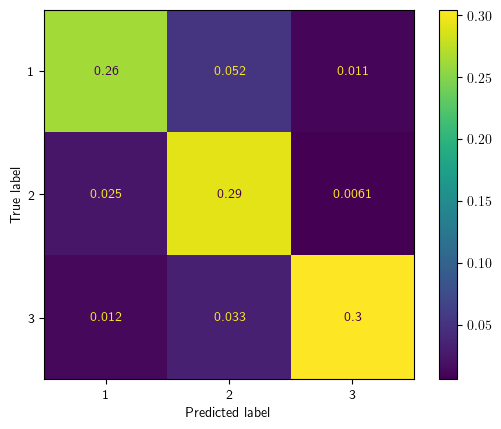

In [75]:
model = Sequential()
model.add(Dense(15, input_dim=X3.shape[1], activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(y_cat.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

itime = time.time()
model_trace = model.fit(X3_train,y3_train,verbose=0,epochs=100)
fit_time = time.time() - itime

itime = time.time()
y3_pred = model.predict(X3_test)
pred_time = time.time() - itime

print("===RESULTS================================")
print("Fit time: %.3f"%fit_time)
print("Prediction time: %.3f"%pred_time)
evaluate(y3_pred,y_test,None)

## HL(30, relu), HL(15, relu)

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_79 (Dense)            (None, 30)                120       
                                                                 
 dense_80 (Dense)            (None, 15)                465       
                                                                 
 dense_81 (Dense)            (None, 3)                 48        
                                                                 
Total params: 633
Trainable params: 633
Non-trainable params: 0
_________________________________________________________________
31/31 [==============================] - 0s 976us/step
===RESULTS================================
Fit time: 12.049 s
Prediction time: 0.110 s
Accuracy: 0.85
Recall: 0.86


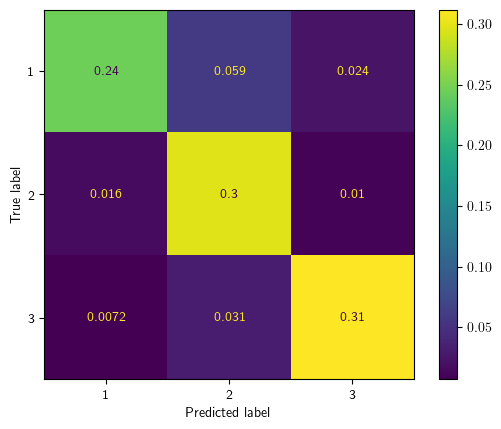

In [76]:
model = Sequential()
model.add(Dense(30, input_dim=X3.shape[1], activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(y_cat.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

itime = time.time()
model_trace = model.fit(X3_train,y3_train,verbose=0,epochs=100)
fit_time = time.time() - itime

y3_pred = model.predict(X3_test)

print("===RESULTS================================")
print("Fit time: %.3f s"%fit_time)
evaluate(y3_pred,y_test,None)

## HL(60, relu), HL(50, relu), HL(40, relu), HL(30, relu)

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_82 (Dense)            (None, 60)                240       
                                                                 
 dense_83 (Dense)            (None, 50)                3050      
                                                                 
 dense_84 (Dense)            (None, 40)                2040      
                                                                 
 dense_85 (Dense)            (None, 30)                1230      
                                                                 
 dense_86 (Dense)            (None, 3)                 93        
                                                                 
Total params: 6,653
Trainable params: 6,653
Non-trainable params: 0
_________________________________________________________________
31/31 [==============================] - 0s 1ms/ste

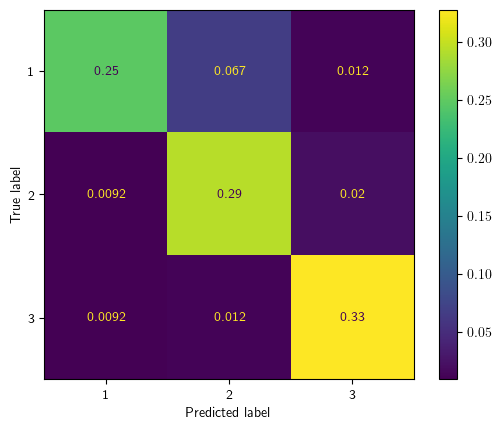

In [77]:
model = Sequential()
model.add(Dense(60, input_dim=X3.shape[1], activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(y_cat.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

itime = time.time()
model_trace = model.fit(X3_train,y3_train,verbose=0,epochs=100)
fit_time = time.time() - itime

y3_pred = model.predict(X3_test)

print("===RESULTS================================")
print("Fit time: %.3f"%fit_time)
print("Prediction time: %.3f"%pred_time)
evaluate(y3_pred,y_test,None)

## HL(100, relu), HL(100, relu), HL(100, relu), HL(100, relu) - BEST ONE

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_186 (Dense)           (None, 100)               400       
                                                                 
 dense_187 (Dense)           (None, 100)               10100     
                                                                 
 dense_188 (Dense)           (None, 100)               10100     
                                                                 
 dense_189 (Dense)           (None, 100)               10100     
                                                                 
 dense_190 (Dense)           (None, 3)                 303       
                                                                 
Total params: 31,003
Trainable params: 31,003
Non-trainable params: 0
_________________________________________________________________
31/31 [==============================] - 0s 1ms/s

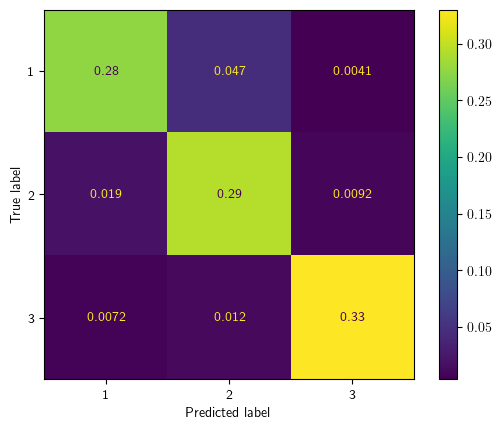

In [108]:
model = Sequential()
model.add(Dense(100, input_dim=X3.shape[1], activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(y_cat.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

itime = time.time()
model_trace = model.fit(X3_train,y3_train,verbose=0,epochs=150)
fit_time = time.time() - itime

y3_pred = model.predict(X3_test)

print("===RESULTS================================")
print("Fit time: %.3f s"%fit_time)
evaluate(y3_pred,y_test,None)

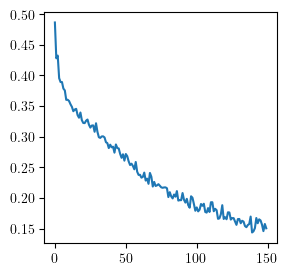

In [109]:
plt.figure(figsize=(3,3))
    
plt.plot(model_trace.history['loss'])

# Model evaluation

In [111]:
pca = PCA(3) 
X3_raw = pca.fit_transform(X_raw)

67/67 [==============================] - 0s 1ms/step
===RESULTS================================
Accuracy: 0.43
Recall: 0.37


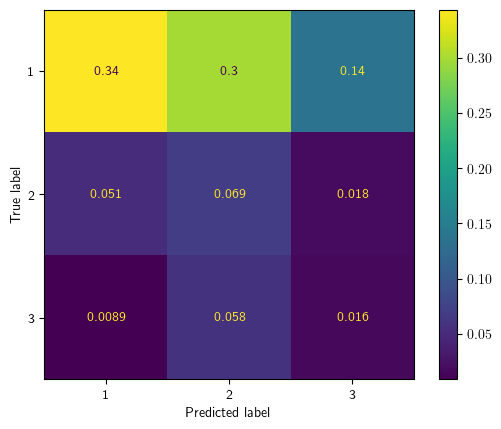

In [117]:
y3_pred = model.predict(X3_raw)

print("===RESULTS================================")
y_pred = np.argmax(y3_pred, axis=1)
y_compare = y_raw-1
    
print("Accuracy: %.2f"%accuracy_score(y_pred,y_compare))
print("Recall: %.2f"%recall_score(y_pred,y_compare,average="macro"))


cm = confusion_matrix(y_compare, y_pred, normalize="all")

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["1","2","3"])
disp.plot()
